# Mini Project 1: Data Ingestion and Wrangling

### All Imports

In [473]:
import pandas as pd
import imaplib
import email
import os
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from email.header import decode_header
from dotenv import load_dotenv
from IPython.display import display

## Data Source: E-mail

### 1. Load data from an e-mail

##### Setup credentials

In [474]:
# Load the variables from the .env file
load_dotenv()

my_email = os.getenv("EMAIL_ADDRESS")
my_app_password = os.getenv("EMAIL_PASSWORD")

gmail_host = "imap.gmail.com"

##### Connect to host server & login

In [475]:
# Set connection
mail = imaplib.IMAP4_SSL(gmail_host)

# Login
mail.login(my_email, my_app_password)

# Select inbox to read from
mail.select("INBOX")

('OK', [b'3'])

##### Method for decoding emails and file attachments

In [476]:
def DecodeEmails(found_emails, download_dir="mail_attachments"):
    # Get the current working directory
    current_path = os.getcwd()

    # Ensure the download directory exists (it will be created in the current path)
    download_path = os.path.join(current_path, download_dir)
    if not os.path.exists(download_path):
        os.makedirs(download_path)

    # Empty list to store all the email datas
    email_data = [] 

    # mail.search() method returns a list of single binary data representing emails ID in bytes
    email_ids = found_emails[0].split()

    for email_id in email_ids:
        try:
            # Fetch the email by ID
            _, msg_data = mail.fetch(email_id, "(RFC822)")

            for response_part in msg_data:
                if isinstance(response_part, tuple):
                    # Get email content
                    email_message = email.message_from_bytes(response_part[1])

                    # Decode the subject 
                    subject = decode_header(email_message.get("Subject", "(No Subject)"))[0][0]
                    if isinstance(subject, bytes):
                        subject = subject.decode('utf-8', errors='ignore')

                    # Get the sender's email address
                    sender = decode_header(email_message.get("From", "Unknown Sender"))[0][0]
                    if isinstance(sender, bytes):
                        sender = sender.decode('utf-8', errors='ignore')

                    # Get the receiving email address
                    receiver = email_message.get("To", "Unknown Recipient")

                    # Get the date of the email
                    date = email_message.get("Date", "Unknown Date")

                    # Empty body variables for email body content
                    plain_body = ""
                    html_body = ""

                    # Empty file attachment list to store attached files
                    attachments = []

                    # Walk through the email parts
                    for part in email_message.walk():
                        content_type = part.get_content_type()
                        content_disposition = str(part.get("Content-Disposition", ""))

                        # Handle attachments
                        if "attachment" in content_disposition or part.get_filename():
                            filename = part.get_filename()
                            # If the file does not have a proper filename
                            if not filename:
                                # Use a generic name with a number and no extension
                                filename = f"file_{len(attachments)+1}"
                            
                            # Decode filename
                            filename = decode_header(filename)[0][0]
                            if isinstance(filename, bytes):
                                filename = filename.decode('utf-8', errors='ignore')
                            
                            # Clean filename but preserve the original extension
                            cleaned_name = []
                            extension = ""
                            if '.' in filename:
                                # Split into name and extension
                                *name_parts, ext = filename.split('.')
                                base_name = '.'.join(name_parts)
                                extension = f".{ext}" if ext else ""
                            else:
                                base_name = filename

                            # Clean the base name (without extension)
                            for c in base_name:
                                if c.isalnum() or c in (' ', '_', '-'):
                                    cleaned_name.append(c)

                            # Reconstruct filename with cleaned base and original extension
                            filename = f"{''.join(cleaned_name).strip()}{extension}"

                            # Ensure unique filename
                            base, ext = os.path.splitext(filename)
                            counter = 1
                            while os.path.exists(os.path.join(download_dir, filename)):
                                filename = f"{base}_{counter}{ext}"
                                counter += 1
                            
                            # Save the attachment
                            try:
                                file_data = part.get_payload(decode=True)
                                if file_data:
                                    filepath = os.path.join(download_dir, filename)
                                    with open(filepath, 'wb') as f:
                                        f.write(file_data)

                                    attachments.append({
                                        "filename": filename
                                    })
                                    
                            except Exception as e:
                                print(f"Failed to save attachment {filename}: {str(e)}")
                        
                        # Handle email body
                        elif content_type == "text/plain" and "attachment" not in content_disposition:
                            try:
                                body_part = part.get_payload(decode=True)
                                if body_part:
                                    plain_body += body_part.decode('utf-8', errors='ignore').replace("\r\n", "\n")
                            except Exception as e:
                                print(f"Error decoding plain text body: {str(e)}")

                        elif content_type == "text/html" and "attachment" not in content_disposition:
                            try:
                                body_part = part.get_payload(decode=True)
                                if body_part:
                                    html_body += body_part.decode('utf-8', errors='ignore').replace("\r\n", "\n")
                            except Exception as e:
                                print(f"Error decoding HTML body: {str(e)}")

                    # Use HTML body if plain text is empty
                    body = plain_body if plain_body else html_body

                    # Add all info to email_data
                    email_data.append({
                        "Subject": subject,
                        "From": sender,
                        "To": receiver,
                        "Date": date,
                        "Body": body,
                        "Attachments": attachments 
                    })

        except Exception as e:
            print(f"Error processing email {email_id}: {str(e)}")
            continue

    return email_data

##### Select types of mails to read

In [477]:
# # Select mails from specific email address
# mail_sender = os.getenv("MAIL_SENDER")
# search_criteria = f'(FROM "{mail_sender}")'
# status, selected_mails = mail.search(None, search_criteria)

# Search for all emails
search_criteria = 'ALL'
status, selected_mails = mail.search(None, search_criteria)

# Empty list to store the email data
email_data = [] 

# Check for chosen emails
if status == "OK" and selected_mails[0]:
    email_data = DecodeEmails(selected_mails)
else:
    print("No emails found.")

##### Display first found email as plain text

In [478]:
print(f"Subject: {email_data[0]['Subject']}")
print(f"From: {email_data[0]['From']}")
print(f"To: {email_data[0]['To']}")
print(f"Date: {email_data[0]['Date']}")
print(f"Body: {email_data[0]['Body']}")
print(f"Attachments: {email_data[0]['Attachments']}")
print("-" * 40)

Subject: Test email
From: orniliya petersen <orniliyaap@gmail.com>
To: "business.int2025@gmail.com" <business.int2025@gmail.com>
Date: Fri, 11 Apr 2025 10:57:28 +0200
Body: Hi there,

This is a test email. Please disregard.

Best regards,
Liya

Attachments: []
----------------------------------------


### 2. Transforming and ingesting the data

In [479]:
df = pd.DataFrame(email_data)

display(df)

,Subject,From,To,Date,Body,Attachments
0,Test email,orniliya petersen <orniliyaap@gmail.com>,"""business.int2025@gmail.com"" <business.int2025...","Fri, 11 Apr 2025 10:57:28 +0200","Hi there,\n\nThis is a test email. Please disr...",[]
1,Quick Check-In,orniliya petersen <orniliyaap@gmail.com>,"""business.int2025@gmail.com"" <business.int2025...","Fri, 11 Apr 2025 10:59:05 +0200","Hey you,\n\nI hope you're doing well. I just w...",[]
2,Dataset for screen time,orniliya petersen <orniliyaap@gmail.com>,"""business.int2025@gmail.com"" <business.int2025...","Fri, 11 Apr 2025 13:39:32 +0200",\n,[{'filename': 'screen_time.csv'}]


### 3. Explore and clean the data

#### Basic exploration

In [480]:
# View first few rows
df.head()

,Subject,From,To,Date,Body,Attachments
0,Test email,orniliya petersen <orniliyaap@gmail.com>,"""business.int2025@gmail.com"" <business.int2025...","Fri, 11 Apr 2025 10:57:28 +0200","Hi there,\n\nThis is a test email. Please disr...",[]
1,Quick Check-In,orniliya petersen <orniliyaap@gmail.com>,"""business.int2025@gmail.com"" <business.int2025...","Fri, 11 Apr 2025 10:59:05 +0200","Hey you,\n\nI hope you're doing well. I just w...",[]
2,Dataset for screen time,orniliya petersen <orniliyaap@gmail.com>,"""business.int2025@gmail.com"" <business.int2025...","Fri, 11 Apr 2025 13:39:32 +0200",\n,[{'filename': 'screen_time.csv'}]


In [481]:
# Check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Subject      3 non-null      object
 1   From         3 non-null      object
 2   To           3 non-null      object
 3   Date         3 non-null      object
 4   Body         3 non-null      object
 5   Attachments  3 non-null      object
dtypes: object(6)
memory usage: 276.0+ bytes


In [482]:
# Check for missing values
df.isna().sum()

Subject        0
From           0
To             0
Date           0
Body           0
Attachments    0
dtype: int64

#### Cleaning the data

###### Handle unwanted spaces

In [483]:
# Remove unwanted spaces or extra newlines just in case
df['Body'] = df['Body'].str.strip()


###### Handle missing data

In [484]:
# Fill only when the 'Body' is NaN or is an empty string after stripping
df['Body'] = df['Body'].apply(lambda x: 'No content' if pd.isna(x) or x == '' else x)

#display(df)


###### Ensure Date is formatted correctly

In [485]:
# Convert the 'Date' column to datetime and then format it
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

### 4. Handle Anonymization

#### Anonymize the sender and receiver

###### Function for finding first name of sender

In [486]:
def extract_first_name(value):
    if pd.isna(value) or not isinstance(value, str):
        return 'Unknown'
    
    # If it's already just a single word assume it's a first name
    if '@' not in value and len(value.split()) == 1:
        return value.capitalize()
    
    # Check if value contains your email
    if my_email and my_email.lower() in value.lower():
        return 'Me'

    # Try to extract name before the email
    match = re.match(r'(?:"?([^"<]+)"?\s)?<?[\w\.-]+@[\w\.-]+>?', value)
    if match:
        full_name = match.group(1)
        if full_name:
            return full_name.strip().split()[0].capitalize()

    # If no name match, fallback: extract from email before @
    email_match = re.search(r'([\w\.-]+)@', value)
    if email_match:
        return email_match.group(1).split('.')[0].capitalize()

    return 'Unknown'

###### Anonymize 'From' and 'To'

In [487]:
# Anonymize sender
df['From'] = df['From'].apply(extract_first_name)
# Anonymize receiver
df['To'] = df['To'].apply(extract_first_name)

display(df.head())

,Subject,From,To,Date,Body,Attachments
0,Test email,Orniliya,Me,2025-04-11 10:57:28+02:00,"Hi there,\n\nThis is a test email. Please disr...",[]
1,Quick Check-In,Orniliya,Me,2025-04-11 10:59:05+02:00,"Hey you,\n\nI hope you're doing well. I just w...",[]
2,Dataset for screen time,Orniliya,Me,2025-04-11 13:39:32+02:00,No content,[{'filename': 'screen_time.csv'}]


### 5. Apply Vizualisation

#### Visualize the distribution of email senders

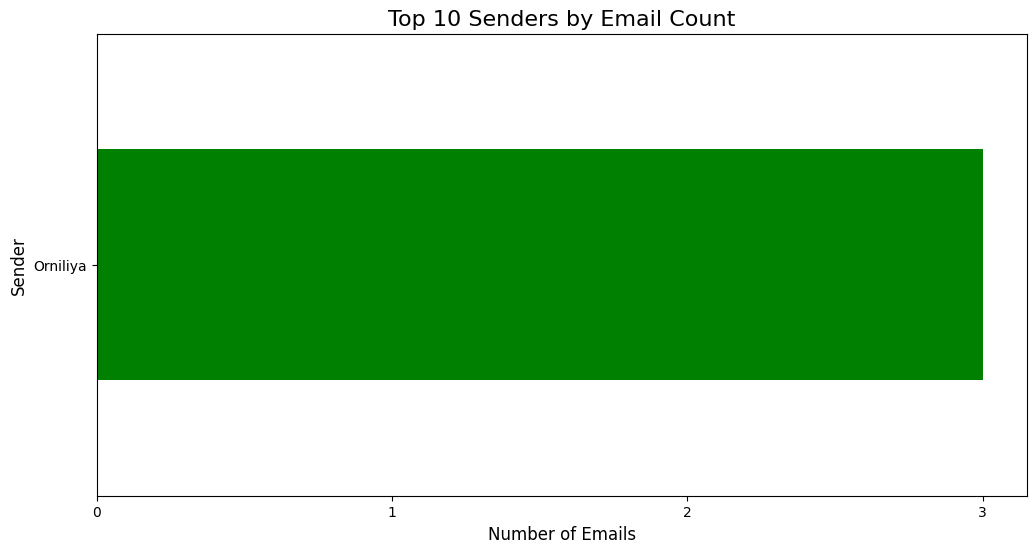

In [488]:
# Count the number of emails from each sender
sender_counts = df['From'].value_counts()

# Plot the distribution of emails sent by each sender (top 10 senders)
plt.figure(figsize=(12, 6))
sender_counts.head(10).plot(kind='barh', color='green')
plt.title('Top 10 Senders by Email Count', fontsize=16)
plt.xlabel('Number of Emails', fontsize=12)
plt.ylabel('Sender', fontsize=12)

# Show only whole numbers on the x-axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

The above horizontal bar graph ranks the top 10 senders by the amount of emails sent to the receiver - It puts the senders with the most sent emails at the top.

The Y-axis shows the first name of the sender, since the full detail of the sender has been anonymized.

The X-axis shows the number of emails sent and only displayed as whole numbers on the axis.

This gives us a quick visual comparison of who contributes the most to the volume of emails in our inbox and could help us with things, such as: <br>
    &nbsp; *1.* Identifying potential spam/notification sources <br>
    &nbsp; *2.* Revealing the main email correspondents <br>
    &nbsp; *3.* Prioritizing whose email to check first

#### Visualize frequency of emails by date

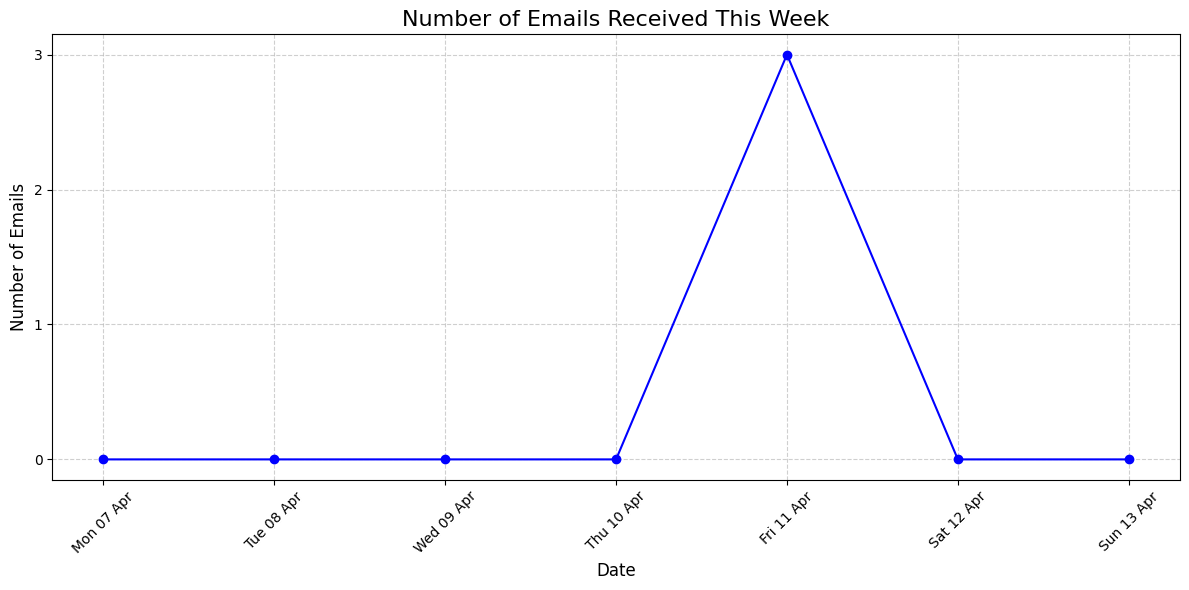

In [ ]:
# Convert df['Date'] to naive (timezone-less) to avoid comparison issues
df['Date'] = df['Date'].dt.tz_localize(None)

# Get today's date and the start of this week (Monday)
today = pd.Timestamp.today().normalize()
start_of_week = today - pd.Timedelta(days=today.weekday())

# Filter only emails from this week
df_this_week = df[df['Date'] >= start_of_week]

# Get date without time for daily counts
df_this_week['Date_Only'] = df_this_week['Date'].dt.date

# Count emails per day
daily_email_count = df_this_week['Date_Only'].value_counts().sort_index()

# Ensure all 7 days are present 
# Fill 0 for missing days
week_dates = pd.date_range(start=start_of_week, periods=7).date
daily_email_count = pd.Series([daily_email_count.get(day, 0) for day in week_dates], index=week_dates)

# Plot number of emails per day
plt.figure(figsize=(12, 6))
plt.plot(daily_email_count.index, daily_email_count.values, marker='o', color='blue')
plt.title('Number of Emails Received This Week', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Emails', fontsize=12)
plt.xticks(rotation=45)

# Format x-axis to show dates nicely - Like "Mon 08 Apr"
plt.gca().set_xticks(week_dates)
plt.gca().set_xticklabels([day.strftime('%a %d %b') for day in week_dates])

# Format y-axis to show whole numbers
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

The above line chart shows the amount of emails the recipent (our own email) receive each day of this current week.

The X-axis shows days of the week from Monday to Sunday including the date and month.

The Y-axis shows the number of emails received in whole numbers.

The dots on the blue line represent the exact email count for the given day while the connecting lines between the dots shows the trend across the days.

This gives us a quick visual comparison of what days are the busiest days in terms of receiving emails and could help us with things, such as: <br>
    &nbsp; *1.* Identifying a weekly pattern of communication flow <br>
    &nbsp; *2.* Revealing perhaps unexpected emails on weekends <br>
    &nbsp; *3.* Planning when we need some email-reading time <br>

#### Visualize the length of email body by sender

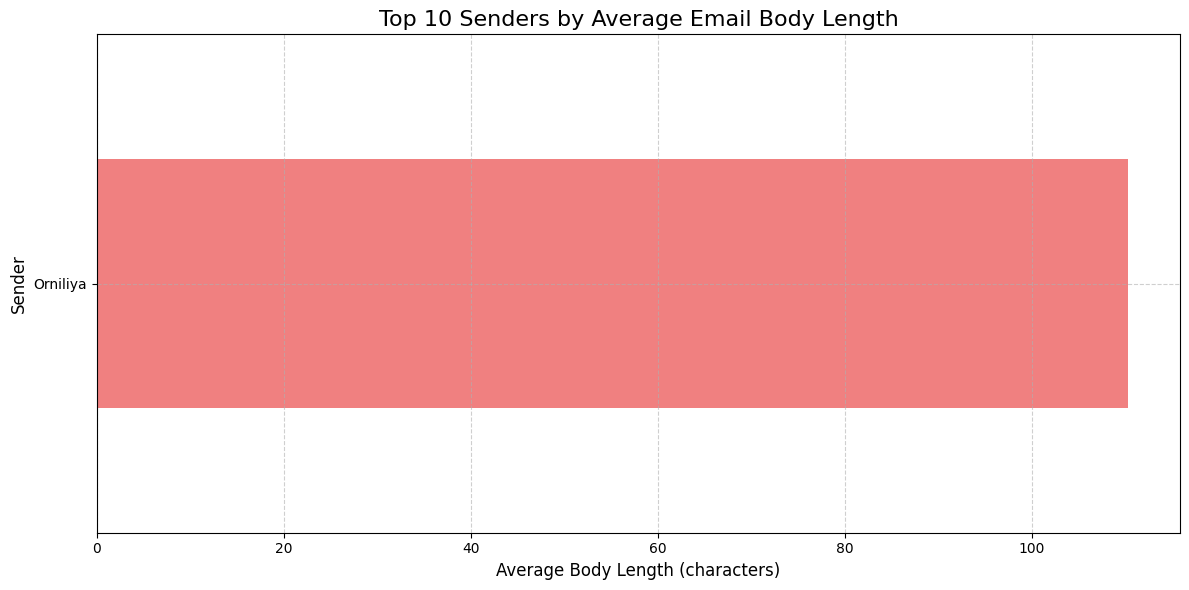

In [490]:
# Create a new column for Subject Length
df['Body_Length'] = df['Body'].apply(len)

# Group by sender and calculate average body length
sender_avg_length = df.groupby('From')['Body_Length'].mean().sort_values(ascending=False)

# Plot average body length by sender
plt.figure(figsize=(12, 6))
sender_avg_length.head(10).plot(kind='barh', color='lightcoral')
plt.title('Top 10 Senders by Average Email Body Length', fontsize=16)
plt.xlabel('Average Body Length (characters)', fontsize=12)
plt.ylabel('Sender', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The above horizontal bar graph ranks the top 10 email senders based on who writes the longest emails on average - It puts the senders with the longest average emails at the top.

The Y-axis shows the first name of the sender, since the full detail of the sender has been anonymized.

The X-axis shows the average number of characters in their emails.

This gives us a quick visual comparison of email length habits across different senders and could help us with things, such as: <br>
    &nbsp; *1.* Prioritizing whose emails need more/less reading time <br>
    &nbsp; *2.* Identifying who sends the most long-winded messages